# Subsetting climate variables over a watershed

Hydrological models are driven by precipitation, temperature and a number of other variables depending on the processes that are simulated. These variables are typically provided by networks of weather stations. For practicality, these point values are often interpolated over space to create *gridded products*, that is, arrays of climate variables over regular coordinates of time and space.

Global hydrological models however require time series of average climate variables over the entire watersheds. When the watershed includes multiples stations, or covers multiple grid cells, we first need to average these multiple stations or grids to yield a single value per time step. The Raven modeling framework can work directly with gridded datasets, provided the configuration includes the weights to apply to the array. For example, all grid cells outside of the watershed could be given weights of 0, while all grid cells inside given a weight proportional to the area of the grid that is inside the watershed.

The Python wrapper does not however support the automatic creation of these grid weights. In the mean time, to use gridded products to drive Raven model simulations, we first need to subset and average gridded data over the watershed. Here we use the processes from two PAVICS services to extract the contour of a watershed and use it to average a gridded dataset: the raven server extracts the watershed contour, and the flyingpigeon server does the subsetting and averaging.

In [13]:
# Import the necessary libraries.

%matplotlib inline
import os

import birdy
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.geometry as sgeo
from ravenpy.utilities.testdata import get_file

In [2]:
# Set the links to the remote servers. If you run these services locally, the default ports that the WPS services are mapped to are 9099 for Raven and 8093 for Flyingpigeon, that is:
# Local Raven URL: http://localhost:9099/wps
# Local Flyingpigeon URL: http://localhost:8093/wps

# Links to the remote servers
url_flyingpigeon = os.environ.get("FLYINGPIGEON_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/flyingpigeon/wps")

url_raven = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")

# Establish client connexions to the remote servers
raven = birdy.WPSClient(url_raven) #, progress=True)
fp = birdy.WPSClient(url_flyingpigeon) # , progress=True)

## Extracting the watershed countour and sub-basins identifiers

Let's consider trying to identify a sub-basin and all the upstream basins that flow into Lac Mistassini (Rupert Watershed) of Northern Quebec. Lac Mistassini is roughly found at 51.0 North, 73.621 West.

We'll start by launching a process with Raven to find the upstream watersheds. The process, called `hydrobasins_select`, takes as an input geographical point coordinates, finds the HydroSheds sub-basin including this point, then looks up into the HydroSheds database to find all upstream sub-basins. It returns the polygon of the watershed contour as a GeoJSON file, as well as a list of all the sub-basins IDs within the watershed.

In [3]:
# Send a request to the server and get the response.
hydrobasin_resp = raven.hydrobasins_select(
    location="-73.621, 51.000", aggregate_upstream=True)

# Wait for the process to complete before continuing with calculations.

In [31]:
# Collecting the response: the watershed contour and the sub-basins ids
feature, sb_ids = hydrobasin_resp.get(asobj=True)

'Number of subbasins: 325'

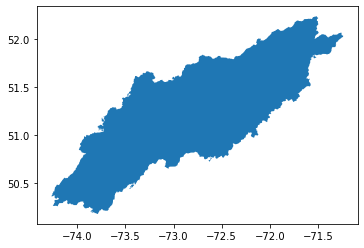

In [34]:
# Plot our vector shapefile
df = gpd.GeoDataFrame.from_features([feature])
df.plot()

display(f"Number of subbasins: {len(sb_ids)}")

## Subsetting a gridded climate dataset

The upstream IDs uniquely identify individual features within the "Hydrobasin" database, which is hosted on the PAVICS GeoServer instance. The process called `subset_wfs_polygon` is precisely meant to subset netCDF files based on features served through the WFS protocol, which is supported by GeoServer. What we are essentially doing is telling the process to grab the polygon from the GeoServer, and use it to subset a gridded data product. 

Note that due to a size limit on HTTP GET requests, passing a large number of subbasin ids will fail. We are working on this, and in the following, are only using 2 subbasins instead of the 325 identified.

In [25]:
# NBVAL_SKIP

# Address of the GeoServer where the HydroBASINS data is pulled from
geoserver = "https://pavics.ouranos.ca/geoserver/wfs"

# A link to a remote file or the path to a local file.
nc_file = get_file("cmip5/tas_Amon_CanESM2_rcp85_r1i1p1_200601-210012_subset.nc")

# Send a request to the flyingpigeon server
resp = fp.subset_wfs_polygon(
    resource=nc_file.as_posix(),
    typename="public:USGS_HydroBASINS_lake_na_lev12", # The store and name of the data set
    geoserver=geoserver, # The address of the GeoServer
    featureids=sb_ids[:2], # The IDs of the individual features
)

 owslib.wps.WPSException : {'code': 'NoApplicableCode', 'locator': 'None', 'text': 'Process failed, please check server error log'}


In [26]:
# Get the output files and plot the temperature time series averaged over the sub-basins.
ds, meta = resp.get(asobj=True)
plt.plot(ds.tas.squeeze())

ProcessFailed: Sorry, process failed.